# Keras MobileNet Benchmark

In a previous benchmark we used a simple three layer ConvNet. This time we use a deeper MobileNet architecture on greyscale strokes. 

This kernel has three main components:

* MobileNet
* Fast and memory efficient Image Generator with temporal colored strokes
* Full training & submission with Kaggle Kernel

I did some paramer search but it should not be hard to improve the current score.

## Setup
Import the necessary libraries and a few helper functions.

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
# import cv2
import pandas as pd
import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
# from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

In [5]:
DP_DIR = 'shuffle-csvs/'
INPUT_DIR = 'quickdraw-doodle-recognition/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
# tf.set_random_seed(seed=1987)

# def f2cat(filename: str) -> str:
#     return filename.split('.')[0]

# def list_all_categories():
#     files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
#     return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:

# ## Training with Image Generator

# In[8]:


from cifar10_policies import good_policies
from augmentation_transforms import *

my_policies = good_policies()

cnt = 0

def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

import pickle


def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    global cnt 
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            chunk = 0
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                #print(x.shape)
                epoch_policy = my_policies[np.random.choice(len(my_policies))]
               
                chunk += 1 
                transformed_x = []
               
                if augment:
                    for i in range(x.shape[0]):
                        x3 = np.dstack((x[i],x[i],x[i]))
                        final_img = apply_policy(epoch_policy, x3)
                
                        sing_img = final_img[:,:,0]
                        sing_img = np.reshape(sing_img,(64,64,1))
                        transformed_x.append(sing_img)
                else:
                    transformed_x = x  
                #transformed_x = x
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield np.asarray(transformed_x), y

In [ ]:
final_img = apply_policy(epoch_policy, x3)

In [5]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## MobileNet

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

In [6]:
STEPS = 800
EPOCHS = 16
size = 64
batchsize = 680

In [7]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

## Training with Image Generator

In [8]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [9]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [10]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

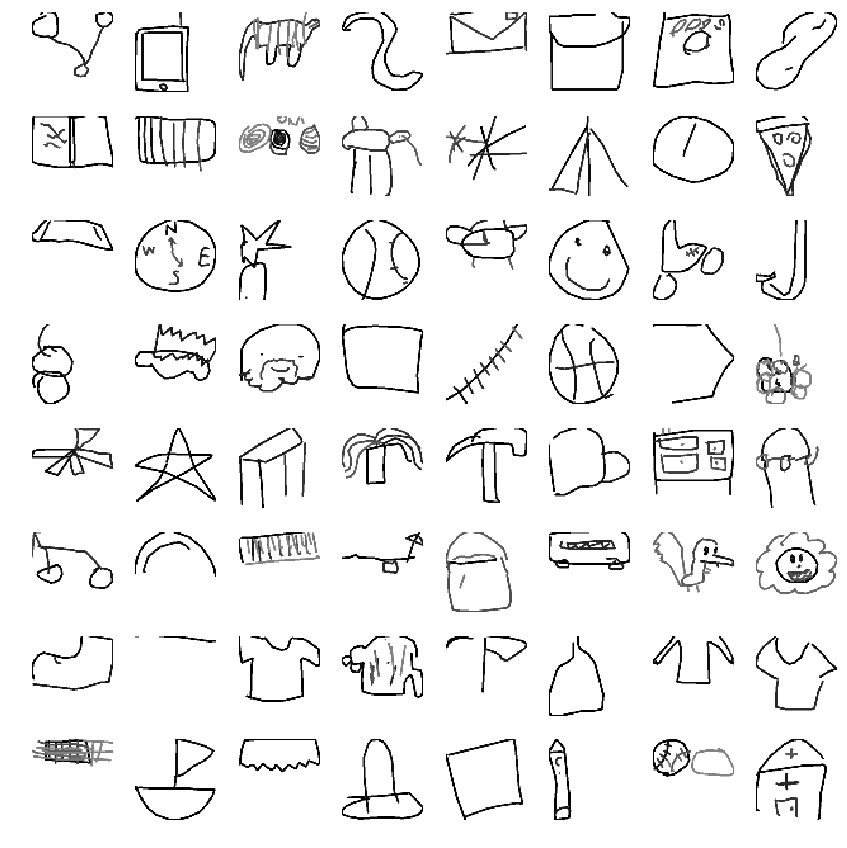

In [11]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [10]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/16
800/800 [==============================] - 215s 269ms/step - loss: 2.8514 - categorical_crossentropy: 2.8514 - categorical_accuracy: 0.3635 - top_3_accuracy: 0.5486 - val_loss: 3.2909 - val_categorical_crossentropy: 3.2909 - val_categorical_accuracy: 0.3296 - val_top_3_accuracy: 0.5344
Epoch 2/16
800/800 [==============================] - 209s 261ms/step - loss: 1.6678 - categorical_crossentropy: 1.6678 - categorical_accuracy: 0.5873 - top_3_accuracy: 0.7852 - val_loss: 2.2222 - val_categorical_crossentropy: 2.2222 - val_categorical_accuracy: 0.4723 - val_top_3_accuracy: 0.6898
Epoch 3/16
800/800 [==============================] - 212s 266ms/step - loss: 1.4498 - categorical_crossentropy: 1.4498 - categorical_accuracy: 0.6356 - top_3_accuracy: 0.8224 - val_loss: 1.7283 - val_categorical_crossentropy: 1.7283 - val_categorical_accuracy: 0.5766 - val_top_3_accuracy: 0.7792
Epoch 4/16
800/800 [==============================] - 221s 276ms/step - loss: 1.3357 - categorical_crossen

In [11]:
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/16
800/800 [==============================] - 212s 265ms/step - loss: 1.0026 - categorical_crossentropy: 1.0026 - categorical_accuracy: 0.7423 - top_3_accuracy: 0.8922 - val_loss: 1.0565 - val_categorical_crossentropy: 1.0565 - val_categorical_accuracy: 0.7292 - val_top_3_accuracy: 0.8845
Epoch 2/16
800/800 [==============================] - 207s 258ms/step - loss: 0.9860 - categorical_crossentropy: 0.9860 - categorical_accuracy: 0.7459 - top_3_accuracy: 0.8947 - val_loss: 4.4737 - val_categorical_crossentropy: 4.4737 - val_categorical_accuracy: 0.1729 - val_top_3_accuracy: 0.3050
Epoch 3/16
800/800 [==============================] - 206s 257ms/step - loss: 0.9686 - categorical_crossentropy: 0.9686 - categorical_accuracy: 0.7497 - top_3_accuracy: 0.8971 - val_loss: 1.0057 - val_categorical_crossentropy: 1.0057 - val_categorical_accuracy: 0.7424 - val_top_3_accuracy: 0.8942
Epoch 4/16
800/800 [==============================] - 202s 253ms/step - loss: 0.9584 - categorical_crossen

In [12]:
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/16
800/800 [==============================] - 207s 259ms/step - loss: 0.8609 - categorical_crossentropy: 0.8609 - categorical_accuracy: 0.7780 - top_3_accuracy: 0.9115 - val_loss: 0.8692 - val_categorical_crossentropy: 0.8692 - val_categorical_accuracy: 0.7740 - val_top_3_accuracy: 0.9107
Epoch 2/16
800/800 [==============================] - 202s 252ms/step - loss: 0.8537 - categorical_crossentropy: 0.8537 - categorical_accuracy: 0.7788 - top_3_accuracy: 0.9128 - val_loss: 0.8674 - val_categorical_crossentropy: 0.8674 - val_categorical_accuracy: 0.7762 - val_top_3_accuracy: 0.9125
Epoch 3/16
800/800 [==============================] - 204s 255ms/step - loss: 0.8535 - categorical_crossentropy: 0.8535 - categorical_accuracy: 0.7786 - top_3_accuracy: 0.9132 - val_loss: 1.1139 - val_categorical_crossentropy: 1.1139 - val_categorical_accuracy: 0.7137 - val_top_3_accuracy: 0.8783
Epoch 4/16
800/800 [==============================] - 205s 256ms/step - loss: 0.8453 - categorical_crossen

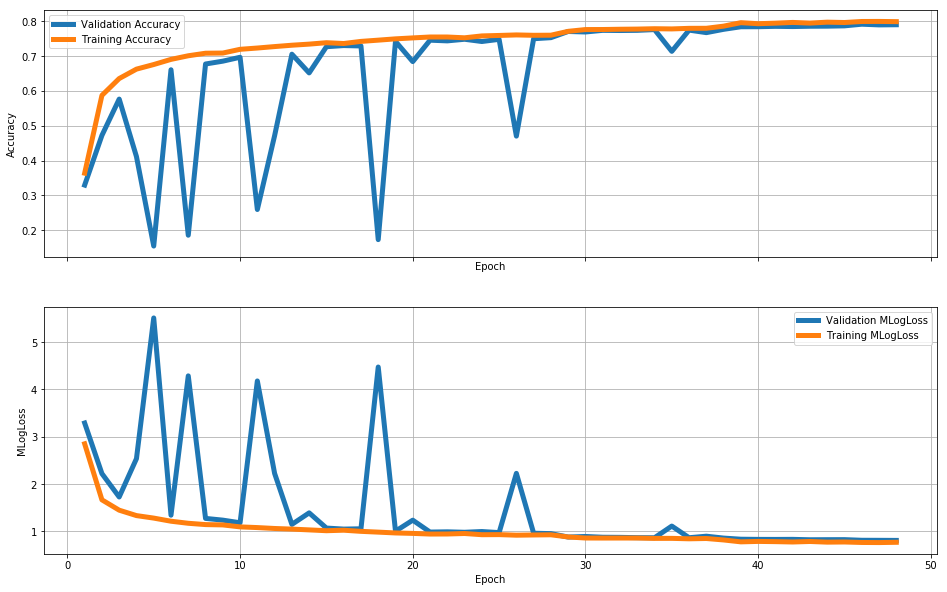

In [13]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [14]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

34000/34000 [==============================] - 4s 120us/step
Map3: 0.846


## Create Submission

In [16]:
test = pd.read_csv(os.path.join('.', 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 64, 64, 1)
Test array memory 1.71 GB


In [18]:
def list_all_categories():
    files = os.listdir(os.path.join('.', 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [19]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 11s 101us/step


,a,b,c
0,234,281,1
1,144,36,226
2,305,62,110
3,187,303,69
4,113,56,112


(112199, 3)

,a,b,c
0,radio,stereo,alarm_clock
1,hockey_puck,bottlecap,pool
2,The_Great_Wall_of_China,castle,fence
3,mountain,tent,church
4,fireplace,campfire,fire_hydrant


(112199, 3)

In [20]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('gs_mn_submission_{}.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,radio stereo alarm_clock
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent church
4,9000052667981386,fireplace campfire fire_hydrant


(112199, 2)

In [21]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2018-11-22 09:47:40.510042.
Total time 53131s
